# History matching

This notebook demonstrates a pipeline for adaptation (history matching) of the real-world reservoir model to match daily recorded well's production rates. Adaptation is based on gradient propagation through the neural network model used for reservoir simulation as it is described in the paper [End-to-end neural network approach to 3D reservoir simulation and adaptation](https://arxiv.org/abs/2102.10304).

### Content
1. [Initialization](#Initialization)
2. [Load the reservoir model](#Load-the-reservoir-model)
3. [Load the metamodel](#Load-the-metamodel)
4. [Rates module](#Rates-module)
4. [Define adapdation space](#Define-adapdation-space)
5. [Target wells set up](#Target-wells-set-up)
5. [Load target rates](#Load-target-rates)
7. [Adaptation period set up](#Adaptation-period-set-up)
8. [Run adaptation](#Run-adaptation)
9. [Analysis of correction factors](#Analysis-of-correction-factors)
9. [Inference on the full period](#Inference-on-the-full-period)
9. [Plot predicted rates](#Plot-predicted-rates)

## Initialization

Required imports

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from deepfield import Field
from deepfield.metamodelling import init_metamodel

from deepfield.datasets import FieldDataset, FieldSample
from deepfield.datasets.transforms import ToTensor, Normalize, AutoPadding, Denormalize
from deepfield.metamodelling.rates import RatesModule

from nb_utils import (loss_plot, hist_plots, slice_view, cumulative_plots,
                      corr_plots, gas_oil_plot)

device = torch.device('cuda')

Specify the reservoir model and initial preprocessing (convertion to `torch` tensors, normalization and appropriate padding):

In [2]:
SAMPLE_ATTRS = {
    'masks': ['actnum', 'time', 'well_mask', 'named_well_mask', 'cf_mask', 'perf_mask'],
    'states': ['pressure', 'soil', 'swat', 'sgas', 'rs'],
    'rock': ['poro', 'permx', 'permy', 'permz'],
    'tables': ['pvto', 'pvtw', 'pvdg', 'swof', 'sgof'],
    'control': ['bhpt']
}

dataset = FieldDataset(src='fields/', sample_attrs=SAMPLE_ATTRS)
dataset.load_statistics('model_stats.pkl')
dataset.set_transform([ToTensor, Normalize, AutoPadding])

## Load the reservoir model

Here we obtain a sample with preprocessed reservoir model data:

In [3]:
sample = next(iter(dataset))

Spatial size of the model and number of active cells

In [4]:
print('Dimensions:', list(sample.masks.actnum.shape))
print('Active cells:', sample.masks.actnum.sum().item())

Dimensions: [148, 124, 212]
Active cells: 1335384


Hint: to save time it is recommended to dump sample into the .hdf5 file:
```python
sample.dump('sample_dump.hdf5', state=True)
```
Then, one can restore the sample as follows:
```python
sample = FieldSample('sample_dump.hdf5').load()
sample.transformed(ToTensor, inplace=True)
```

To save space on GPU, we avoid moving the full sample to the device. Instead, only time-independent parameters go to GPU first:

In [5]:
for k in sample.tables.keys():
    sample.tables[k] = sample.tables[k].to(device)
sample.masks.actnum = sample.masks.actnum.long().to(device)
sample.masks.well_mask = sample.masks.well_mask.to(device)

control_t = sample.masks.control_t.unsqueeze(0).to(device)
t = sample.masks.time.unsqueeze(0).to(device)
s_init = sample.states[:1].clone().to(device)
params = sample.rock.clone().unsqueeze(0).to(device)
actnum = sample.masks.actnum

Larger tensors we leave on CPU and will move to GPU only small slices of these tensors

In [6]:
cf_mask = sample.masks.cf_mask.clone()
perf_mask = sample.masks.perf_mask.clone()
base_control = sample.control.clone()

We will also need a sample that contains data at well blocks only

In [7]:
sample_at_wells = sample.at_wells(inplace=False)

## Load the metamodel

Init and load the pre-trained metamodel

In [8]:
autoenc_path = 'ae_module.pt'
lsd_path = 'lsd_module.pt'

lsd, ae_kwargs, kwargs = init_metamodel(autoenc_path=autoenc_path,
                                        lsd_path=lsd_path,
                                        z_ch=32,
                                        max_integration_timestep=1000,
                                        use_checkpointing=True,
                                        use_inner_checkpointing=True,
                                        max_in_batch=1,
                                        max_seq_len=10,
                                        atol=1e-3,
                                        device=device)

## Rates module
Init the differentiable (`torch` based) model for production rates calculation

In [9]:
rates_module = RatesModule(units='METRIC').to(device)

## Define adapdation space

Tensor `rock_coefs` contains additive correction factors for upscaled `ROCK` properties

In [10]:
shape = sample.rock.shape
rock_coefs = 0.01*torch.randn((1, 4) + tuple(i//4 for i in shape[1:])).to(device)
rock_coefs.requires_grad = True

`up` module upscales rock correction factors to the full shape

In [11]:
up = torch.nn.Upsample(size=shape[-3:])

Tensor `cf_coefs` contains corrections for connection factors of the wells

In [12]:
cf_coefs = 0.01*torch.randn((sample.masks.well_mask > 0).sum()).to(device)
cf_coefs.requires_grad = True

Define an optimizer on the space of `rock_coefs` and `cf_coefs` variables with appropriate `learning_rate` and `weight decay` parameters

In [13]:
optimizer = optim.Adam([rock_coefs, cf_coefs], lr=0.3, weight_decay=0.0005)

## Target wells set up

Here we specify a set of target wells for adaptation

In [14]:
target_wells = np.array(['well_1', 'well_2', 'well_3', 'well_4', 'well_5', 'well_6',
                         'well_7', 'well_8', 'well_9', 'well_10', 'well_11', 'well_12'])

## Load target rates
Separately, we load daily production rates that will be used as adaptation targets and convert them to torch tensors:

In [15]:
n_timesteps = 365 + 181 #adaptation + forecast period in days

model = Field('fields/field_model.hdf5').load()

dates = model.wells.result_dates[:n_timesteps]

target_rates = {}
for name in target_wells:
    rates = model.wells[name].total_rates.set_index('DATE')
    df = pd.DataFrame(index=dates).join(rates).fillna(0)
    vals = df[['WWPR', 'WGPR', 'WOPR']].values.astype(float)
    target_rates[name] = torch.Tensor(vals).to(device)

INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, ACTNUM, COORD, DIMENS, ZCORN
INFO:Field:ROCK attributes: PERMX, PERMY, PERMZ, PORO
INFO:Field:STATES attributes: PRESSURE, RS, SGAS, SOIL, SWAT
INFO:Field:TABLES attributes: DENSITY, PVDG, PVTO, PVTW, ROCK, SGOF, SWOF
INFO:Field:WELLS attributes: BLOCKS, RESULTS, BLOCKS_INFO, HISTORY, EVENTS, PERF, WELLTRACK
INFO:Field:=========================
INFO:Field:Grid pillars (`COORD`) are mapped to new axis with respect to `MAPAXES`.


## Adaptation period set up

Here we specify time segments on which we will run adaptation. The segments cover 1 year in total:

In [16]:
max_len = 10
n_timesteps_train = 365

train_segments = np.arange(0, n_timesteps_train + max_len, max_len)
train_segments = np.clip(train_segments, 0, n_timesteps_train-1)
print(train_segments)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 364]


## Run adaptation

Adaptation is an iterative procedure. First we iterate over time segments. On each segment we calculate production rates, compute loss function and accumulate gradients with respect to the adaptation variables. At the end of the adaptation period we update adaptation variables according to the gradients accumulated and repeat the iterations.

In [17]:
loss_hist = []

sample.sample_attrs.rates = ['BWPR', 'BGPR', 'BOPR'] #MAKE SURE THE SAME ORDER IN TARGETS!

for _ in range(150):
    loss_sum = 0
    z_init = lsd.state_enc(s_init, **ae_kwargs)

    for l, r in zip(train_segments[:-1], train_segments[1:]):
        params_actn = (params + up(rock_coefs)) * actnum #apply rock correction
        r_params = lsd.params_enc(params_actn, **ae_kwargs)
        s_control, s_control_t = lsd.get_control_subset(base_control.unsqueeze(0), control_t,
                                                        (t[0, l], t[0, r]))
        s_control = s_control.to(device)
        r_control = lsd.control_enc(s_control, **ae_kwargs)
        z_pred_piece = lsd._compute_dynamics((z_init, r_params, r_control), s_control_t,
                                             t[:, l:r+1], **kwargs)

        s_pred_piece = lsd._decode(z_pred_piece, **ae_kwargs)

        sample.states = s_pred_piece[0]
        sample.control = s_control[0]
        sample.rock = params_actn[0]

        sample.masks.time = t[0, l:r+1]
        sample.masks.control_t = s_control_t[0]
        sample.masks.cf_mask = cf_mask[l:r].to(device)
        sample.masks.perf_mask = perf_mask[l:r].to(device)

        sample.state.normalized = True
        sample = sample.transformed(Denormalize, inplace=False)
        sample.states = torch.clamp(sample.states, min=0)
        sample.rock = torch.clamp(sample.rock, min=0)

        rates = rates_module(sample)
        rates = torch.clamp(rates, min=0)

        rates = rates * torch.exp(cf_coefs) #apply CF correction

        loss = 0
        for name in target_wells:
            targ = target_rates[name][l+1:r+1]
            mask = sample_at_wells.masks.named_well_mask[name]
            pred = rates[..., mask.bool()].sum(dim=-1) * (targ != 0)
            log_pred = torch.log(1 + pred)
            log_targ = torch.log(1 + targ)
            loss += ((log_pred - log_targ)**2).mean()
        loss = loss / len(target_wells)

        z_init = z_pred_piece[:, -1].detach()

        loss.backward()
        loss_sum += loss.item()

    optimizer.step()
    optimizer.zero_grad()
    loss_hist.append(loss_sum)

Plot the adaptation loss decay against iterations

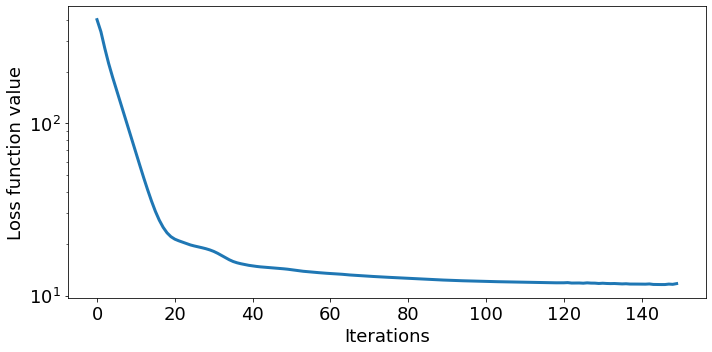

In [18]:
loss_plot(loss_hist, logscale=True)

## Analysis of correction factors

Some data preparation. Here we translate tensors to `numpy` arrays, get rock corrections at active cells and connectivity corrections at the target wells.

In [19]:
up_rock_coefs = up(rock_coefs)
final_params = ((params + up_rock_coefs) * actnum).detach().cpu().numpy()[0]
initial_params = params.detach().cpu().numpy()[0]
rock_diff = up_rock_coefs[..., actnum==1].detach().cpu().numpy().ravel()

cf_coefs_at_wells = []
for name in target_wells:
    mask = sample_at_wells.masks.named_well_mask[name].bool()
    cf_coefs_at_wells.append(cf_coefs[mask].detach().cpu().numpy())
cf_coefs_at_wells = np.exp(np.hstack(cf_coefs_at_wells))

target_wells_mask = np.zeros(model.well_mask.shape).astype(bool)
for name in target_wells:
    target_wells_mask[model.well_mask == name] = True

Plot distributions of the rock and connectivity correction factors

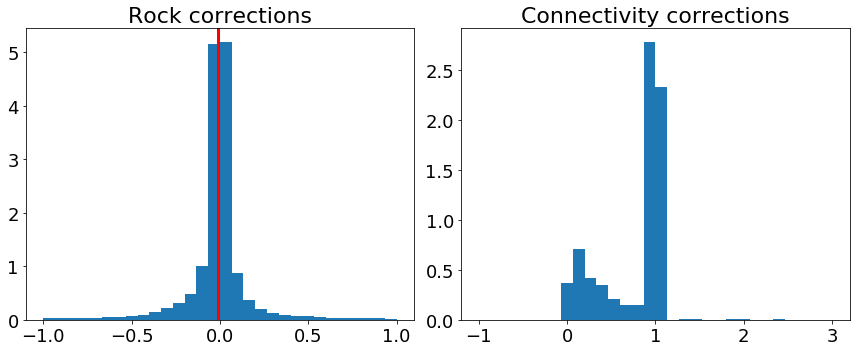

In [20]:
hist_plots(rock_diff, cf_coefs_at_wells)

Slice view of the initial and final porosity and the difference

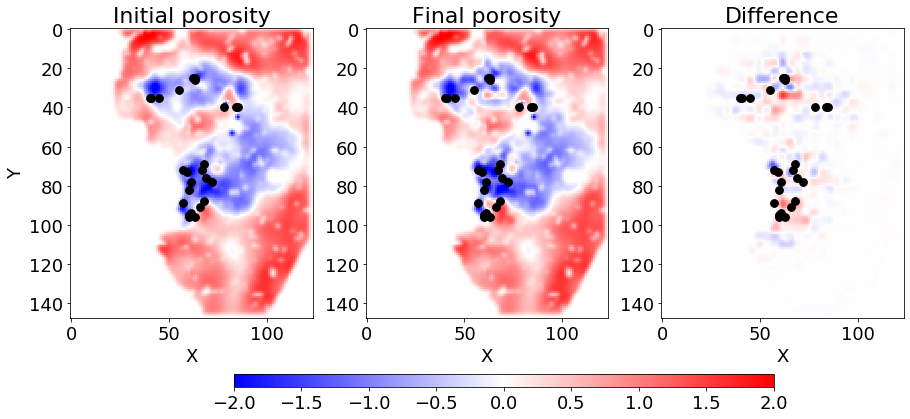

In [21]:
slice_view(initial_params[0], final_params[0], target_wells_mask, cv=2,
           z_ind=50, name='porosity')

Slice view for the x-permeability

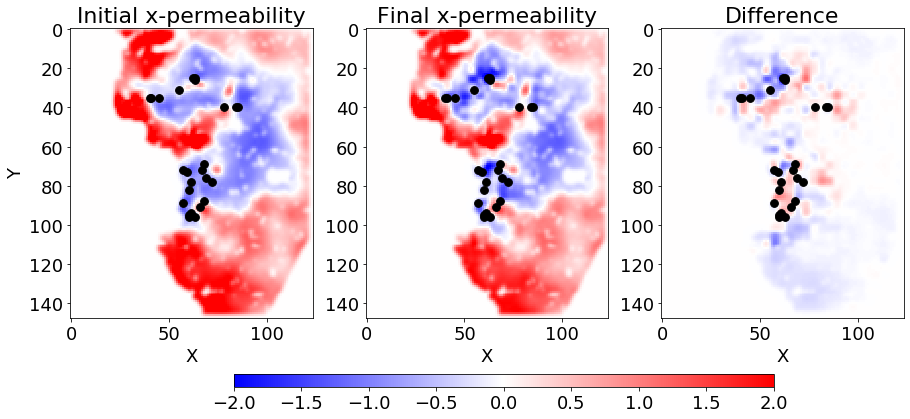

In [22]:
slice_view(initial_params[1], final_params[1], target_wells_mask, cv=2,
           z_ind=50, name='x-permeability', save='./JPSE_plots/Figure_9.pdf')

## Inference on the full period

Specify time segments on which we will run the simulation. The segments cover 1.5 year in total:

In [23]:
test_segments = np.arange(0, n_timesteps + max_len, max_len)
test_segments = np.clip(test_segments, 0, n_timesteps-1)
print(test_segments)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 545]


Run inference

In [24]:
rates_pred = []
sample.sample_attrs.rates = ['BWPR', 'BGPR', 'BOPR'] 

with torch.no_grad():
    z_init = lsd.state_enc(s_init, **ae_kwargs)
    params_actn = (params + up(rock_coefs)) * actnum #apply rock correction
    r_params = lsd.params_enc(params_actn, **ae_kwargs)
    for l, r in zip(test_segments[:-1], test_segments[1:]):
        s_control, s_control_t = lsd.get_control_subset(base_control.unsqueeze(0),
                                                        control_t,
                                                        (t[0, l], t[0, r]))
        s_control = s_control.to(device)
        r_control = lsd.control_enc(s_control, **ae_kwargs)
        z_pred_piece = lsd._compute_dynamics((z_init, r_params, r_control), s_control_t,
                                             t[:, l:r+1], **kwargs)

        s_pred_piece = lsd._decode(z_pred_piece, **ae_kwargs)

        sample.states = s_pred_piece[0]
        sample.control = s_control[0]
        sample.rock = params_actn[0]

        sample.masks.time = t[0, l:r+1]
        sample.masks.control_t = s_control_t[0]
        sample.masks.cf_mask = cf_mask[l:r].to(device)
        sample.masks.perf_mask = perf_mask[l:r].to(device)

        sample.state.normalized = True
        sample = sample.transformed(Denormalize, inplace=False)
        sample.states = torch.clamp(sample.states, min=0)
        sample.rock = torch.clamp(sample.rock, min=0)

        rates = rates_module(sample, inplace=False)
        rates = torch.clamp(rates, min=0)

        rates = rates * torch.exp(cf_coefs) #apply CF correction

        rates_pred.append(rates.detach().cpu().numpy())

        z_init = z_pred_piece[:, -1].detach()

rates_pred = np.vstack(rates_pred)

## Plot predicted rates

Collect target and predicted rates over target wells in `numpy` arrays:

In [25]:
np_targets = []
np_pred = []

for name in target_wells:
    targ = target_rates[name].detach().cpu().numpy()
    np_targets.append(targ[1:n_timesteps])
    mask = sample_at_wells.masks.named_well_mask[name].detach().cpu().numpy()
    pred = rates_pred[..., mask!=0].sum(axis=-1) #sum over all well blocks
    np_pred.append(pred)

np_targets = np.array(np_targets)
np_pred = np.array(np_pred)

Plot cumulative production rates computed for all target wells

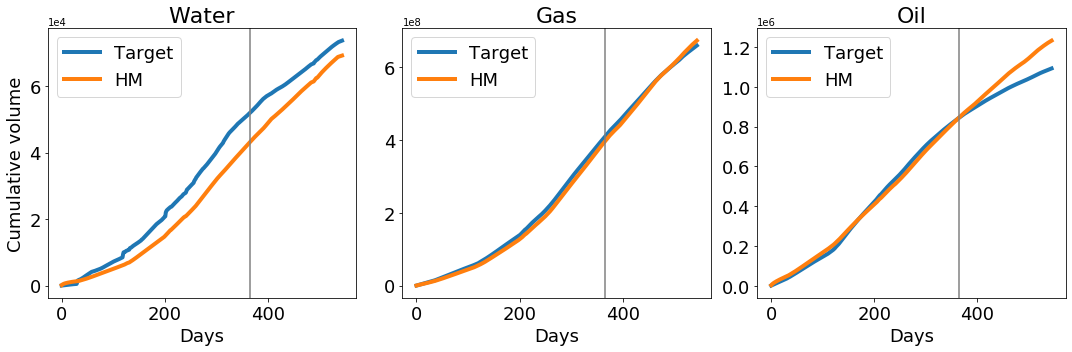

In [26]:
phases = [{'G': 'Gas', 'O': 'Oil', 'W': 'Water'}[k[1]]
          for k in sample.sample_attrs.rates]

cumulative_plots(np_targets.sum(axis=0), np_pred.sum(axis=0), phases,
                 vline=n_timesteps_train)

Correlation between target and predicted cumulative production rates for individual wells

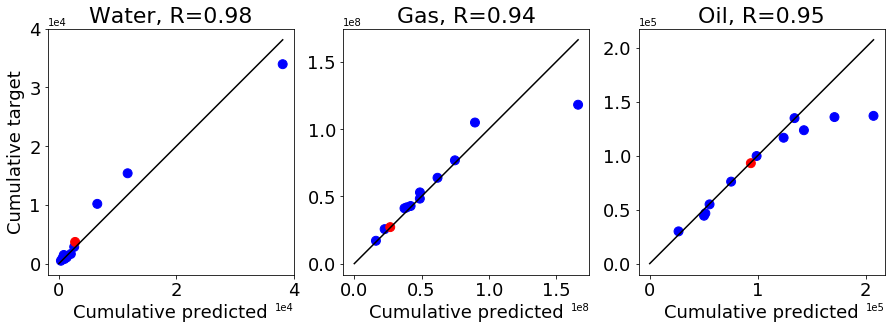

In [27]:
corr_plots(np_targets, np_pred_full, phases, mark_well=sample_well_id)

Cumulative plot for the sample well

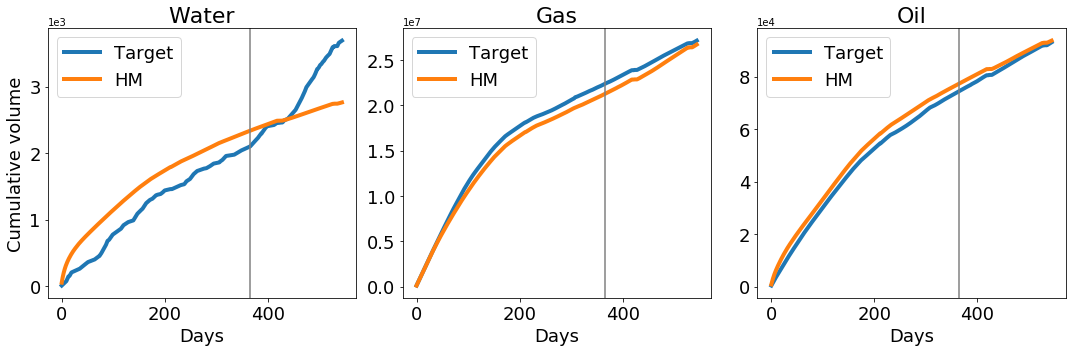

In [28]:
cumulative_plots(np_targets[sample_well_id], np_pred[sample_well_id], phases,
                 vline=n_timesteps_train)

Gas/oil ratio

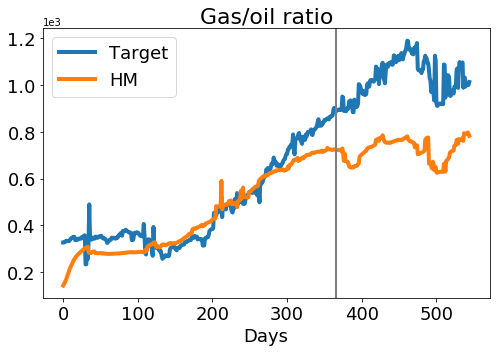

In [29]:
gas_oil_plot(np_targets[..., 1].sum(axis=0),
             np_pred[..., 1].sum(axis=0),
             np_targets[..., 2].sum(axis=0),
             np_pred[..., 2].sum(axis=0),
             vline=n_timesteps_train)

Done! We demonstrated the adaptation pipeline and obtained the model that reproduces daily production rates reasonably well.